<a href="https://colab.research.google.com/github/adibayaseen/HKRCPI/blob/main/code/withSuperdrug_RankofFirstPositiveProtein_SVM_nr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q condacolab

In [ ]:
import condacolab
condacolab.install()#install_miniconda()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [ ]:
!conda install -c bioconda cd-hit

Solving environment: \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cd-hit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    cd-hit-4.8.1               |       h2e03b76_5         251 KB  bioconda
    certifi-2021.10.8          |   py37h89c1867_1         145 KB  conda-forge
    conda-4.11.0               |   py37h89c1867_0        16.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        17.4 MB

The following NEW packages will be INSTALLED:

  cd-hit             bioconda/linux-64::cd-hit-4.8.1-h2e03b76_5

The following packages will be UPDATED:

  ca-certificates                      2020.12.5-ha878542_0 --> 2021.10.8-ha878542_0
  certifi                  

In [ ]:
!pip install biopython

     |████████████████████████████████| 2.3 MB 5.0 MB/s 
     |████████████████████████████████| 15.7 MB 57.5 MB/s 


In [ ]:
!mamba install -c conda-forge rdkit

Streaming output truncated to the last 5000 lines.
xorg-xextproto           [] (00m:00s) Waiting...
greenlet                 [] (00m:00s) Validating...
libxcb                   [] (00m:00s)     15 KB /    391 KB (  8.27 KB/s)
sqlalchemy               [] (00m:00s)     15 KB /      2 MB (  8.27 KB/s)
libstdcxx-ng             [] (00m:01s) Waiting...
libblas                  [] (00m:01s) Decompressing...
libgfortran-ng           [] (00m:01s) Waiting...
gettext                  [] (00m:01s) Waiting...
libglib                  [] (00m:01s) Waiting...
libwebp-base             [] (00m:01s) Waiting...
olefile                  [] (00m:01s) Waiting...
libtiff                  [] (00m:01s) Waiting...
libopenblas              [] (00m:01s) Waiting...
pillow                   [] (00m:01s) Waiting...
pthread-stubs            [] (00m:01s) Waiting...
matplotlib-base          [] (00m:01s) Waiting...
pyparsing                [] (00m:01s) Waiting...
pytz                     [] (00m:01s) Waiting...
pandas  

In [ ]:
from rdkit import Chem

ImportError: ignored

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 10 20:01:32 2021
@author: fayya
"""
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
#rdkit.Avalon.pyAvalonTools.GetAvalonCountFP((object)mol[, (int)nBits=512[, (bool)isQuery=False[, (int)bitFlags=15761407]]])
def LoadSuperDrugdata():
  path='/content/drive/MyDrive/CPI_Data/'
  import pandas as pd
  df_Superdrug=pd.read_excel(path+'approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values#index_col=2)
  df_Superdrug=df_Superdrug[1:]
  ###Names
  SuperdrugNames=pd.read_excel(path+'approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#index_col=2)
  SuperdrugNames=SuperdrugNames[1:]
  SuperdrugNames=np.array([c[0] for c in SuperdrugNames])
  df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
  CompoundFeatures = np.array([getFP(s) for s in df_Superdrug_Compounds])
  return CompoundFeatures,SuperdrugNames 
#from rdkit.Avalon import pyAvalonTools as pat
def getFP(s,r = 3,nBits = 1024):        
    compound = Chem.MolFromSmiles(s.strip())
    fp = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits = nBits)
    #fp = pat.GetAvalonCountFP(compound,nBits=nBits)
    m = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, m)     
    return m
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

import random
import numpy as np
def NRKFold(E,pc,K = 5, shuffle=True):
    """
    Generate non-redundant K-folds so that no two folds contain proteins
    belonging to the same cluster and the number of examples are (approx)
    equal in all folds. Implements the greedy number partitioning method
    https://en.wikipedia.org/wiki/Greedy_number_partitioning
    >>> NRKFold(['p1','p2','p3','p4','p5','p6','p1'],{'p1':1,'p2':2,'p3':1,'p4':2,'p5':3,'p6':3},K=2, shuffle = False)
    Here we have 7 examples involving 6 proteins p1-p6 such that proteins
    p1,p3,p5 form one cluster whereas p2,p4,p6 form another cluster
    This results in division into two folds as [[0, 2, 6], [1, 3, 4, 5]]
    Note that examples 0,2,6 comprising fold-1 with proteins p1 and p2 are 
    from the first cluster whereas the remaining examples are from other clusters
    Parameters
    ----------
    E : TYPE List (length equal to number of examples)
        DESCRIPTION. Protein id of protein involved in each example
    pc : TYPE dictionary 
        DESCRIPTION. Cluster assignment of each protein
    K : TYPE, optional Integer
        DESCRIPTION. Number of folds The default is 5.
    shuffle: TYPE, Boolean
        cluster to fold assignments are different across different runs
    Returns
    -------
    F : TYPE list of lists
        DESCRIPTION. Indices of examples in E in each fold
    """
    e = [pc[str(x)] for x in E] #cluster indices of all proteins in the examples
    c2idx={} #indices of examples of each cluster in e
    for i,x in enumerate(e):
        try: 
            c2idx[x].append(i)
        except:
            c2idx[x]=[i]    
    ce = dict([(c,len(c2idx[c])) for c in c2idx]) #counts of examples of different clusters    
    cF = [0]*K; #counts of examples in each fold
    CF = [[] for _ in range(K)]; #clusters in each fold
    F = [[] for _ in range(K)];#indices of examples in each fold
    keys = list(ce.keys())
    if shuffle:
        random.shuffle(keys)
    for k in keys:
        v = ce[k]
        idx = np.argmin(cF)
        cF[idx]+=v
        CF[idx].append(k) #add cluster to fold
        F[idx].extend(c2idx[k])
    return F
import os
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
def processCDHIT(L,cthresh,ofile="out.cdhit"):#=0.8
    """   
    Generate CD-HIT clustering
    Runs CD-HIT and creates a temporary file which is not deleted automatically
    Parameters
    ----------
    L : TYPE Fasta file string OR List of protein sequences OR  SeqRecord
        DESCRIPTION.
    cthresh : TYPE, optional
        DESCRIPTION. Cutoff threshold The default is 0.8.
    ofile : TYPE, optional
        DESCRIPTION. The default is "out.cdhit".
    Returns
    -------
    cc : TYPE Dictionary with cluster id  as key and list of protein ids in each cluster
        DESCRIPTION. 
    pc: TYPE Dictionary with protein id string as key and cluster id as value
        DESCRIPTION. 
    """
    if type(L)==type(""):
        ifile = L
    else:
        if type(L[0]==type("")):
            L = [SeqRecord(Seq(p),id=str(i)) for i,p in enumerate(L)]
        ifile = ofile+"_temp.fasta"
        with open(ifile, "w") as output_handle:
            SeqIO.write(L, output_handle, "fasta") 
    
    cmd = "cd-hit -i "+ifile+" -d 0 -o "+ofile+" -c "+str(cthresh)+" -n 3  -G 1 -g 1 -b 20 -l 10 -s 0.0 -aL 0.0 -aS 0.0 -T 4 -M 32000"   
    os.system(cmd)
    with open(ofile+".clstr","r") as fh:
        clusters = fh.readlines()
    cc = {}
    for x in clusters:
        xs = x.split()
        if xs[0]=='>Cluster':
            ccid = int(xs[1])
            cc[ccid]=[]
        else:
            pid = xs[2][1:].split('...')[0]
            cc[ccid].append(pid)  
    pc = {}
    for k,v in cc.items():
        for vi in v:
            pc[vi]=k
    return cc,pc

def moltosvg(mol, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')


from Bio import SeqIO
from Bio.SeqIO import FastaIO
from itertools import product
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import math
def twomerFromSeq(s):
    k=2
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))

    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values()  )           #[ 0,0,0,0,0,0,0]
        key=list(count.keys()     )           #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1

    V=V/(len(s)-1)
    return np.array(V)
def threemerFromSeq(s):
    k=3
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))

    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values())              #[ 0,0,0,0,0,0,0]
        key=list(count.keys() )              #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1

    V=V/(len(s)-1)
    return np.array(V)
def prot_feats_seq(seq):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f=[]
    X = ProteinAnalysis(str(seq))
    X.molecular_weight() #throws an error if 'X' in sequence. we skip such sequences
    p=X.get_amino_acids_percent()
    dp=[]
    for a in aa:
        dp.append(p[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    tm=np.array(twomerFromSeq(str(seq)))
    tm=normalize(np.atleast_2d(tm), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(tm[0])
    thm=np.array(threemerFromSeq(str(seq)))
    thm=normalize(np.atleast_2d(thm), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(thm[0])
    return np.array(f)
def DataWrite(Cseq,Pseq,Y, filename):
  path='/content/drive/MyDrive/CPI_Data/'
  filename=open(path+filename+'.txt','w', encoding="utf-8")
  for data in range(len(Cseq)):
    filename.write((Cseq[data]+' '+Pseq[data]+' '+str(Y[data])+"\n"))
def Features_PredictorBindingDB(filename):
  path='/content/drive/MyDrive/CPI_Data/'
  #with open(path+'2p2i_TargetvsNonTargetchain_human.txt') as f:#New_Unique_data.txt') as f:#
  with open(path+filename) as f:
    #with open('./data.txt') as f:#../../celegans/original
    D = f.readlines()
  C=[];P=[];Y=[];Cseq=[];Pseq=[]
  Ids=[];Ligands=[];Complexs=[];Chains=[];
  for d in tqdm(D):
      #Id,Ligand,Complex,Chain,c,p,y = d.split()
      c,p,y = d.split()
      #id,c,p,y = d.split()
      try:
          xc = getFP(c)
          xp = prot_feats_seq(p)
      except Exception as e:
          print(e)
          continue
      Cseq.append(c)
      Pseq.append(p)
      C.append(xc)
      P.append(xp)
      Y.append(float(y))
      ####
      #Ids.append(Id);Ligands.append(Ligand);Complexs.append(Complex);Chains.append(Chain);
  Y = np.array(Y);
  C = np.array(C);
  P = np.array(P);
  return P,C,Y
def Features_Predictor(filename):
  path='/content/drive/MyDrive/CPI_Data/'
  #with open(path+'2p2i_TargetvsNonTargetchain_human.txt') as f:#New_Unique_data.txt') as f:#
  with open(path+filename) as f:
    #with open('./data.txt') as f:#../../celegans/original
    D = f.readlines()
  C=[];P=[];Y=[];Cseq=[];Pseq=[]
  Ids=[];Ligands=[];Complexs=[];Chains=[];
  for d in tqdm(D):
      Id,Ligand,Complex,Chain,c,p,y = d.split()
      #c,p,y = d.split()
      #id,c,p,y = d.split()
      try:
          xc = getFP(c)
          xp = prot_feats_seq(p)
      except Exception as e:
          print(e)
          continue
      Cseq.append(c)
      Pseq.append(p)
      C.append(xc)
      P.append(xp)
      Y.append(2*float(y)-1)
      ####
      Ids.append(Id);Ligands.append(Ligand);Complexs.append(Complex);Chains.append(Chain);
  Y = np.array(Y);
  C = np.array(C);
  P = np.array(P);
  return P,C,Y
def Calculate_RFPP(z,Targetlabels):
  RPP=[]
  index_P=np.argsort(z)
  n=len(Targetlabels)
  sorted_index=index_P[::-1][:n]
  sorted_score=z[index_P[::-1][:n]]
  sorted_Targetlabels=Targetlabels[sorted_index]
  ###
  RPP.append(np.where(sorted_Targetlabels==1))
  RFPP=np.min(RPP)+1
  return RFPP  
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics.pairwise import rbf_kernel as kernel #sigmoid_kernel,rbf_kernel,linear_kernel
from sklearn.model_selection import StratifiedKFold, KFold
import random
if __name__=='__main__':
    path='/content/drive/MyDrive/CPI_Data/'
    #with open(path+'Orignal_CPI_data.txt') as f:#New_Unique_data.txt') as f:#
    #with open('./data.txt') as f:#../../celegans/original
        #D = f.readlines()
    NegtiveRatio='1'
    with open(path+'pos2negtiveRatio'+NegtiveRatio+'_Alpha_threshold_Random.txt') as f:
    #with open('./data.txt') as f:#../../celegans/original
        D = f.readlines()
    C=[];P=[];Y=[];Cseq=[];Pseq=[]
    for d in tqdm(D):
        c,p,y = d.split()
        #id,c,p,y = d.split()
        try:
            xc = getFP(c)
            xp = prot_feats_seq(p)
        except Exception as e:
            print(e)
            continue
        Cseq.append(c)
        Pseq.append(p)
        C.append(xc)
        P.append(xp)
        Y.append(2*float(y)-1)
    Y = np.array(Y)
    C = np.array(C);
    P = np.array(P);
    
#%% Generating negative examples  
    regenerate =  False#True#False#
    if regenerate:
        Pset = list(set(Pseq)) #set of protein sequences
        pidx = list(range(len(Pset))) 
        Pdict = dict(zip(Pset, pidx)) #seq->index
        Cset = list(set(Cseq)) #set of compound sequences
        cidx = list(range(len(Cset)))#
        Cdict = dict(zip(Cset, cidx)) #str->index
        #1/0
        Epairs = np.array([(Pdict[p],Cdict[c]) for (p,c) in zip(Pseq,Cseq)]) #dict of pairs
        pos,negs = Epairs[Y==1,:],Epairs[Y!=1,:] 
        #if the negs are to be sampled such that the both the protein and compound occur in the positive set as well
        pidx,cidx = list(set(pos[:,0])),list(set(pos[:,1])) #replaced with only positive
        #pos, negs = list(map(tuple,pos.tolist())),list(map(tuple,negs.tolist())) #
        #below - remove 100% redundant positive and negative examples -- original redundant examples are not removed otherwise
        pos, negs = list(set(map(tuple,pos.tolist()))),list(set(map(tuple,negs.tolist())))
        NegtiveRatio=5
        NN =NegtiveRatio*len(pos)#len(negs) #
        negs = [] #comment to use the set of original negatives
        Lnegs = len(negs)
        ######## Dissimilarity Criteria for negtive examples
        
        Pos_Pseq=np.array([s[0] for s in pos])#Orignal
        #Pos_PFeatures = np.array([prot_feats_seq(Pset[s[0]]) for s in pos])#orignal
        #Pos_Pseq=np.array([s[0] for s in pos])
        #Pos_Pseq=list (set (Pos_Pseq))#should pick only unique protein 
        Pos_PFeatures = np.array([prot_feats_seq(Pset[s]) for s in Pos_Pseq])#should pick only unique protein 
        Pos_Cseq=np.array([s[1] for s in pos])#orignal
        #Pos_Cseq=list (set (Pos_Cseq))#should pick only unique Compounds 
        #Pos_CFeatures = np.array([getFP(Cset[s[1]]) for s in pos])#orignal
        Pos_CFeatures = np.array([getFP(Cset[s]) for s in Pos_Cseq])#should pick only unique compounds
       
        #######
        Pos_Pscaler = StandardScaler().fit(Pos_PFeatures )
        Pos_Cscaler = StandardScaler().fit(Pos_CFeatures)
        Pos_Ptr,Pos_Ctr = Pos_Pscaler.transform(Pos_PFeatures), Pos_Cscaler.transform(Pos_CFeatures)
        #####
        Kpp = kernel(Pos_Ptr)
        Kcp = kernel(Pos_Ctr)
        Kpp_dict=dict(zip(Pos_Pseq,Kpp))
        Kcp_dict=dict(zip(Pos_Cseq,Kcp))
        ######
        Alpha_threshold='Random'#0.7
        while len(negs)<NN:
          possible = (random.choice(pidx),random.choice(cidx))#(pidx[np.random.randint(0,len(ppos))],cidx[np.random.randint(0,len(cpos))])
          index_P=np.argmax(Kpp_dict[possible[0]])
          new_Spp=np.delete(Kpp[index_P],index_P)
          index_C=np.argmax(Kcp_dict[possible[1]])
          new_Scp=np.delete(Kcp[index_C],index_C)
          Alpha=np.max(new_Spp)*np.max(new_Scp)
          if possible not in pos and possible not in negs:# and Alpha<Alpha_threshold:
              negs.append(possible)        
        print('Added Negatives',len(negs)-Lnegs)
        iPdict = {v: k for k, v in Pdict.items()}
        iCdict = {v: k for k, v in Cdict.items()}
        
        C=[];P=[];Y=[];Cseq=[];Pseq=[]
        for i,(p,c) in tqdm(enumerate(pos+negs)):
            p = iPdict[p]
            c = iCdict[c]
            try:
                xc = getFP(c)
                xp = prot_feats_seq(p)
            except Exception as e:
                print(e)
                continue
            Cseq.append(c)
            Pseq.append(p)
            C.append(xc)
            P.append(xp)
            Y.append(2*(i<len(pos))-1)
        
#%%
    Y = np.array(Y)
    C = np.array(C);
    P = np.array(P);
    ####
    #filename="pos2negtiveRatio"+str (NegtiveRatio)+"_Alpha_threshold_"+str (Alpha_threshold)
    #DataWrite(Cseq,Pseq,Y, filename)
    import itertools
    Pset = list(set(Pseq)) #set of protein sequences
    pidx = list(range(len(Pset))) 
    Pdict = dict(zip(Pset, pidx)) #seq->index
    Cset = list(set(Cseq)) #set of compound sequences
    cidx = list(range(len(Cset)))#
    Cdict = dict(zip(Cset, cidx)) #str->index
    Epairs = np.array([(Pdict[p],Cdict[c]) for (p,c) in zip(Pseq,Cseq)]) #dict of pairs
#%% 
    cc,pc = processCDHIT(Pset,cthresh = 0.9) 
    
    E = list(Epairs[:,0]) #protein id of examples
    F = NRKFold(E,pc,K=5,shuffle=True)   
    
#%%        
    # C = StandardScaler().fit_transform(C)
    # P = StandardScaler().fit_transform(P)
    gp = gc = None
    skf = KFold(n_splits=5,shuffle=True)
    skf = StratifiedKFold(n_splits=5,shuffle=True)        
    F=[list(test_index) for (train_index, test_index) in skf.split(P, Y)] 
    F = NRKFold(E,pc,K=5,shuffle=True) 
    Z = []; Yo = []; A = [];Yp=[]
    AUC_ROC_final=[];Precision_final=[];Recall_final=[];Avg_P_final=[];z_scores_list=[];Targetlabels_list=[];sorted_Names_list=[];Pi_seq_list=[]
    proteinseq_all=[]
    AUC_ROC_External=[]
    ###For RFPP
    pos,negs = Epairs[Y==1,:],Epairs[Y!=1,:] 
    ####Human dataset all unique compounds
    Pos_Cseq=np.array([s[1] for s in pos])#orignal
    Pos_Cseq=list (set (Pos_Cseq))#should pick only unique Compounds 
    Pos_CFeatures = np.array([getFP(Cset[s]) for s in Pos_Cseq])#should pick only unique compounds
    Unique_Compounds_Features_dict=dict (zip(Pos_Cseq,Pos_CFeatures))
    ####SuperDrugbank Compounds
    #path='/content/drive/MyDrive/CPI_Data/'
    """
    import pandas as pd
    df_Superdrug=pd.read_excel(path+'approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values#index_col=2)
    df_Superdrug=df_Superdrug[1:]
    df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
    df_Superdrug_Compounds=list (set (df_Superdrug_Compounds))#only unique 3633
    Superdrug_CFeatures = np.array([getFP(s) for s in df_Superdrug_Compounds])
    """
    Superdrug_CFeatures,SuperdrugNames=LoadSuperDrugdata()
    ####P2C_dict is the protein paired with all compounds in positive set
    from collections import defaultdict
    P2C_dict=defaultdict(list)
    for (key, value) in pos:
      #key,value=Pset[key],Cset[value]
      if key not in P2C_dict:
        P2C_dict[key]=[value]
      else:
        P2C_dict[key]=np.append(P2C_dict.get(key, ()) , value)
    #######
    RFPP_all=[]
    perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]#99
    for f in tqdm(range(len(F))):
      train_index = list(itertools.chain.from_iterable(F[:f]+F[f+1:]))
      test_index = F[f]
      #show number of proteins shared between train and test
      print(len(set([E[x] for x in train_index]).intersection([E[x] for x in test_index])))        
      y_train, y_test = Y[train_index], Y[test_index] 
      Ptr,Ctr = P[train_index,:],C[train_index,:]
      Pscaler = StandardScaler().fit(Ptr)
      Cscaler = StandardScaler().fit(Ctr)
      Ptr,Ctr = Pscaler.transform(Ptr), Cscaler.transform(Ctr)
      
      Kp = kernel(Ptr)
      Kc = kernel(Ctr)
      Ktr = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
      
      clf = SVC(C = 1.0, kernel = 'precomputed',class_weight='balanced')
      clf.fit(Ktr,y_train)
      ####Rank of First positive protein
      test_neg=np.where(y_test[y_test==-1])
      test_pos=np.where(y_test[y_test==1])
      ####
      Unique_PFeature_dict={}
      for s in test_pos[0]:
        #test_Pseqindex.append(Pdict[Pseq[test_pos[0][s]]])
        if Pdict[Pseq[test_pos[0][s]]] not in Unique_PFeature_dict:
          Unique_PFeature_dict[Pdict[Pseq[test_pos[0][s]]]]=P[test_pos[0][s]]
      test_Pseq_Uniqueindex=list (Unique_PFeature_dict.keys())
      ###loop
      for Pi_index in range(len(test_Pseq_Uniqueindex)):
        ####For one example Pi
        Pi=test_Pseq_Uniqueindex[Pi_index ]#pick one protein P index
        Pi_Feature=Unique_PFeature_dict[test_Pseq_Uniqueindex[Pi_index ]]#P features of that index
        #Pos_Cseq#pair with all unique compounds
        #Ctt=Superdrug_CFeatures #Features all unique Compounds of Superdrugbank
        Actual_Compound=P2C_dict[Pi]#Actul_Compound paired with Pi
        Actual_Compound_Features=np.array([Unique_Compounds_Features_dict[c] for c in Actual_Compound])
        Ctt=np.vstack((Actual_Compound_Features,Superdrug_CFeatures ))#Features all unique Compounds of Superdrugbank and truepositive examples
        Ptt=np.array([Pi_Feature for i in range(len(Ctt))])#Copy same feature of protein equal to number of unique compounds
        #Ctt=Pos_CFeatures #Features all unique Compounds of Human dataset
        Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)
        Kp = kernel(Ptt,Ptr)
        Kc = kernel(Ctt,Ctr)
        Ktt = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
        z_scores = clf.decision_function(Ktt)
        ####
        poslabel=1*np.ones(len(Actual_Compound_Features))
        neglabel=-1*np.ones(len(Superdrug_CFeatures))
        Targetlabels=np.append(poslabel,neglabel )
        ###
        #save score all possible (~ 908,250) pairs of proteins from the NR-HCPI with compounds from SuperDRUG2 for one fold only
        #Pi protein Sequence
        #actualcompound SMILES
        #Names of drugs
        #scores
        #Dict[pi]=(Names, Score)#For actual names are SMILES and all others are names drom superdrug2
        #TCS = clf.decision_function(Ktcp)
        ###Sorting
        index_Z=np.argsort(z_scores)
        #n=len(SuperdrugNames)
        sorted_index=index_Z[::-1][:len(Targetlabels)]
        sorted_score=z_scores [sorted_index]#[index_TCS[::-1][:n]]
        sorted_Labels=Targetlabels[sorted_index]
        Names=np.append(np.array([Cseq[i] for i in Actual_Compound ]),SuperdrugNames)
        sorted_Names=Names[sorted_index]
        z_scores_list.extend(sorted_score)
        Targetlabels_list.extend(sorted_Labels)
        Pi_seq_list.extend(np.array([Pseq[Pi] for i in range(len(Targetlabels))]))
        sorted_Names_list.extend(sorted_Names)
        ###Calculate_RFPP(z,Targetlabels)#score,label return RFPP
        #z_random=np.random.uniform(0, 1.0, size=(len(Targetlabels)))
        #z_random=np.random.uniform(0, 1.0, size=(len(Targetlabels)))
        RFPP=Calculate_RFPP(z_scores,Targetlabels)
        #RFPP=Calculate_RFPP(z_random,Targetlabels)
        RFPP_all.append(RFPP)
        proteinseq_all.append(Pseq[Pi])
      1/0
    ####RFPP'
    Average_perntile=np.percentile(RFPP_all,perntile_values)
    np.save(path+'SuperDrugCompounds_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)
    #np.save(path+'Random_SuperDrugCompounds_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)
    plt.figure()
    plt.plot(perntile_values,np.log10 (Average_perntile),color='r',marker='x',label=Alpha_threshold+'_NagtiveRatio_{0:.2f}'.format(NegtiveRatio))
    plt.grid()
    plt.xlabel('Percentile')
    plt.ylabel('log10 RFPP')
    plt.title('RFPP of positive proteins in test with SuperDrug compounds')
    plt.legend()
    1/0
    for fold in range(len(RFPP_Folds)):
      #plt.figure()
      plt.hist(RFPP_Folds[fold])#,label='Fold {:.0f}'.format(fold))#,cumulative=True)
      #plt.legend()
    1/0
    ########
    """
        test_Pseq=Pseq[test_pos]
        Ptt_pos,Ptt_neg=P[test_pos],P[test_neg]
        Ctt_pos,Ctt_neg=C[test_pos],C[test_neg]
        Ptt=np.vstack((Ptt_pos,P_test))
        Ctt=np.vstack((Ctt_pos,C_test))
        #y_test=1*np.ones(len(Ptt_pos))
        y_test=np.append(1*np.ones(len(Ptt_pos)),Y_test)
        print("Total positive=",len(y_test[y_test==1]),"Total negative=",len(y_test[y_test==-1]))
        ####
        Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)

        Kp = kernel(Ptt,Ptr)
        Kc = kernel(Ctt,Ctr)
        Ktt = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)

        z = clf.decision_function(Ktt)
        yp=clf.predict(Ktt)
        auc = roc_auc_score(y_test, z)
        precision = precision_score(y_test, yp)
        recall = recall_score(y_test, yp)
        average_P_score=average_precision_score(y_test, z)
        print("fold Auc:",auc,"precision=",precision,"recall=",recall,"average_P_score=",average_P_score )
        AUC_ROC_final.append(auc);Precision_final.append(precision );Recall_final.append(recall);Avg_P_final.append(average_P_score);Z.extend(list(z));Yo.extend(list(y_test))#;Yp.extend(list(yp))
    """
        ####BindingDB Testing
        #import scipy.stats
    """
        #P_test,C_test,Y_test=Features_Predictor('BindingDB_m62021_data_all.txt')
        P_test,C_test = Pscaler.transform(P_test), Cscaler.transform(C_test)
        
        Kp = kernel(P_test,Ptr)
        Kc = kernel(C_test,Ctr)
        Ktt_test = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
        
        z_test = clf.decision_function(Ktt_test)
        AUC_test=len(z_test[z_test<0])#roc_auc_score(Y_test, z_test)
        print("total negtive data test AUC=",AUC_test,"/",len(Y_test))
        AUC_ROC_External.append(AUC_test)
        #Pearson=scipy.stats.pearsonr(z_test, Y_test)[0] 
        #Spearman=scipy.stats.spearmanr(z_test, Y_test)[0] 
        """
        #######
    """
        auc_test = roc_auc_score(Y_test, z_test)
        yp_test=clf.predict(Ktt_test)
        precision_test = precision_score(Y_test, yp_test)
        recall_test = recall_score(Y_test, yp_test)
        average_precision_score_test=average_precision_score(Y_test, z_test)
        """
        #Pearson_External.append(Pearson);Spearman_External.append(Spearman )
    
    fpr, tpr, thresholds = roc_curve(Yo, Z)  
    auc = roc_auc_score(Yo, Z)
    #####
    plt.plot(fpr,tpr);plt.title(auc);plt.xlabel('FPR');plt.ylabel('TPR');plt.show()
    print("Final average over 5folds",np.average(AUC_ROC_final).round(4),'±',np.std( AUC_ROC_final).round(4),np.average(Precision_final).round(4),'±',np.std( Precision_final).round(4),np.average(Recall_final).round(4),'±',np.std( Recall_final).round(4),np.average(Avg_P_final).round(4),'±',np.std( Avg_P_final).round(4))
    print("Alpha_threshold=",Alpha_threshold,"NegtiveRatio=",NegtiveRatio)#,"AUC=",auc,"Percision=",precision,"Recall=",recall,"average_precision_score",average_P_score)
    #print("BindingDB",np.average(AUC_ROC_External).round(4),'±',np.std( AUC_ROC_External).round(4),np.average(Precision_External).round(4),'±',np.std( Precision_External).round(4),np.average(Recall_External).round(4),'±',np.std( Recall_External).round(4),np.average(Avg_P_External).round(4),'±',np.std( Avg_P_External).round(4))
    #print("BindingDB",np.average(Pearson_External).round(4),'±',np.std( Pearson_External).round(4),np.average(Spearman_External).round(4),'±',np.std( Spearman_External).round(4))
    print("New test",np.average(AUC_ROC_External).round(4),'±',np.std( AUC_ROC_External).round(4))
    1/0
    #####2p2iTest
    P_test,C_test,Y_test=Features_Predictor('2p2i_TargetvsNonTargetchain_human.txt')
    P_test,C_test = Pscaler.transform(P_test), Cscaler.transform(C_test)
    
    Kp = kernel(P_test,Ptr)
    Kc = kernel(C_test,Ctr)
    Ktt_test = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
    
    z_test = clf.decision_function(Ktt_test)
    auc_test = roc_auc_score(Y_test, z_test)
    yp_test=clf.predict(Ktt_test)
    precision_test = precision_score(Y_test, yp_test)
    recall_test = recall_score(Y_test, yp_test)
    average_precision_score_test=average_precision_score(Y_test, z_test)
    print("AUC_test=",auc_test,"Percision_test=",precision_test,"Recall_test=",recall_test,"average_precision_score_test",average_precision_score_test)
    1/0
#%% Training on all 
    
    # Ptr,Ctr = P,C
    # y_train = Y
    # Pscaler = StandardScaler().fit(Ptr)
    # Cscaler = StandardScaler().fit(Ctr)
    # Ptr,Ctr = Pscaler.transform(Ptr), Cscaler.transform(Ctr)
    
    # Kp = kernel(Ptr)
    # Kc = kernel(Ctr)
    # Ktr = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
    
    # clf = SVC(C = 100.0, kernel = 'precomputed',class_weight='balanced')
    # clf.fit(Ktr,y_train)
    
#%% Testing 
    # Lmj_eIF4E4 (Binding residues in yellow) (Binding domain underlined)
    s = 'MSTPLDVRAAEYSPSFAVTMKKTVAAAPPKSPAPAKSKISVTRTGVNTTYPMPPPMPEKNYAPFFAEGCQTIAASKASMPPVQPASPLPPMHSAPPTASVVSNSIPPSSPATAPGERSPAVAARSVPTRFSPATVPRHHMNPNATEFMPGRRNGPDGGLEALPTSTADMELAKTPAGAAAAAVHAPSLPGAVRRSLQNSPIIQPSRLSVKSASEIEAISKNSALNAAAAAYVPQRTLARVVLTQPSPLALAPSEDPAKNNIEMMLDDLWCLFYLPTTLGENIKEEDYNPTLVFRVDSILTFWRVVNNIAAPSELQLSTLYLFRDGIDPKWEDPANRDGGIVKVKATAAQVDEAWELLLCRTIGDSWSPSVRETVNGVVLKVRERAYWLELWVTKNSSALQKDLAELWHPILGASFATTYLTHAMMQERSHAAAALAAEKQKKNRRRY'
    #s = 'MNPNATEFMPGRRNGPDGGLEALPTSTADMELAKTPAGAAAAAVHAPSLPGAVRRSLQNSPIIQPSRLSVKSASEIEAISKNSALN'
    # Lmj_PABP1
    s = 'MAAAVQEAAAPVAHQPQMDKPMQIASIYVGDLDATINEPQLVELFKPFGTILNVRVCRDIITQRSLGYGYVNFDNHDSAEKAIESMNFKRVGDKCVRLMWQQRDPALRYSGNGNVFVKNLEKDVDSKSLHDIFTKFGSILSCKVMQDEEGKSRGYGFVHFKDETSAKDAIVKMNGAADHASEDKKALYVANFIRRNARLAALVANFTNVYIKQVLPTVNKDVIEKFFAKFGGITSAAACKDKSGRVFAFCNFEKHDDAVKAVEAMHDHHIDGITAPGEKLYVQRAQPRSERLIALRQKYMQHQALGNNLYVRNFDPEFTGADLLELFKEYGEVKSCRVMVSESGVSRGFGFVSFSNADEANAALREMNGRMLNGKPLIVNIAQRRDQRYTMLRLQFQQRLQMMMRQMHQPMPFVGSQGRPMRGRGGRQQLGGRAQGHPMPMPSPQQPQAPAQPQGFATPSAVGFVQATPKHSPGDVPETPPLPPITPQELESMSPQEQRAALGDRLFLKVYEIAPELAPKITGMFLEMKPKEAYELLNDQKRLEERVTEALCVLKAHQTA'
    #s = 'LPPITPQELESMSPQEQRAALGDRLFLKVYEIAPELAPKITGMFLEMKPKEAYELLNDQKRLEERVTEALCVLKAHQTA'
    #s = 'SWISSCHEESE'#'MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK'
    #s = 'MFRQEQPLAEGSFAPMGSLQPDAGNASWNGTEAPGGGARATPYSLQVTLTLVCLAGLLMLLTVFGNVLVIIAVFTSRALKAPQNLFLVSLASADILVATLVIPFSLANEVMGYWYFGKAWCEIYLALDVLFCTSSIVHLCAISLDRYWSITQAIEYNLKRTPRRIKAIIITVWVISAVISFPPLISIEKKGGGGGPQPAEPRCEINDQKWYVISSCIGSFFAPCLIMILVYVRIYQIAKRRTRVPPSRRGPDAVAAPPGGTERRPNGLGPERSAGPGGAEAEPLPTQLNGAPGEPAPAGPRDTDALDLEESSSSDHAERPPGPRRPERGPRGKGKARASQVKPGDSLPRRGPGATGIGTPAAGPGEERVGAAKASRWRGRQNREKRFTFVLAVVIGVFVVCWFPFFFTYTLTAVGCSVPRTLFKFFFWFGYCNSSLNPVIYTIFNHDFRRAFKKILCRGDRKRIV'
    #s = 'MSLPNSSCLLEDKMCEGNKTTMASPQLMPLVVVLSTICLVTVGLNLLVLYAVRSERKLHTVGNLYIVSLSVADLIVGAVVMPMNILYLLMSKWSLGRPLCLFWLSMDYVASTASIFSVFILCIDRYRSVQQPLRYLKYRTKTRASATILGAWFLSFLWVIPILGWNHFMQQTSVRREDKCETDFYDVTWFKVMTAIINFYLPTLLMLWFYAKIYKAVRQHCQHRELINRSLPSFSEIKLRPENPKGDAKKPGKESPWEVLKRKPKDAGGGSVLKSPSQTPKEMKSPVVFSQEDDREVDKLYCFPLDIVHMQAAAEGSSRDYVAVNRSHGQLKTDEQGLNTHGASEISEDQMLGDSQSFSRTDSDTTTETAPGKGKLRSGSNTGLDYIKFTWKRLRSHSRQYVSGLHMNRERKAAKQLGFIMAAFILCWIPYFIFFMVIAFCKNCCNEHLHMFTIWLGYINSTLNPLIYPLCNENFKKTFKRILHIRS'
    Cuseq = np.unique(Cseq)
    """
    pp = 'h1'#[]
    with open('../../../../'+pp+"_inactive.txt") as f:
        Cuseq = np.array(f.readlines())
    """
    xp = prot_feats_seq(s)
    Ptt = np.array([xp]*len(Cuseq))
    """
    Cseq = np.array(Cseq)
    Pseq = np.array(Pseq)
    Cuseq=Cseq[test_index]
    Puseq=Pseq[test_index]        
    Ptt = np.array([prot_feats_seq(s) for s in Puseq])
    """
    Ctt = np.array([getFP(c) for c in Cuseq])    
    
    Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)
        
    Kp = kernel(Ptt,Ptr)
    Kc = kernel(Ctt,Ctr)
    Ktt = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
    
    z = clf.decision_function(Ktt)
    """
    yy = Y[test_index]
    fpr, tpr, thresholds = roc_curve(yy, z)  
    auc = roc_auc_score(yy, z)
    plt.plot(fpr,tpr);plt.title(auc);plt.xlabel('FPR');plt.ylabel('TPR');plt.show()
    """

    idx = np.argsort(-z)    
    print(Cuseq[idx[:3]])
    M = [Chem.MolFromSmiles(Cuseq[i]) for i in idx[:10]]
    # for i in idx[:10]:
    #     m = Chem.MolFromSmiles(Cuseq[i])
    #     SVG(moltosvg(m))
#%%
    zpos=list(zpos);zneg=list(zneg)
    yy=[1]*len(zpos)+[-1]*len(zneg)
    zz = zpos+zneg
    fpr, tpr, thresholds = roc_curve(yy, zz)  
    auc = roc_auc_score(yy, zz)
    precision = precision_score(yy, zz)
    recall = recall_score(yy, zz)
    average_precision_score=average_precision_score(yy, zz)
    plt.plot(fpr,tpr);plt.title(auc);plt.xlabel('FPR');plt.ylabel('TPR');plt.show()
    print("AUC=",auc,"Percision=",precision,"Recall=",recall,"average_precision_score",average_precision_score)

100%|██████████| 5266/5266 [00:24<00:00, 212.36it/s]
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [04:24:55] WARNING: not removing hydrogen atom witho

0


  0%|          | 0/5 [10:09<?, ?it/s]


ZeroDivisionError: ignored

In [ ]:
pip install xlsxwriter

     |████████████████████████████████| 149 kB 5.1 MB/s 


In [ ]:
####
import xlsxwriter
path='/content/drive/MyDrive/CPI_Data/'
Filename=path+'Target Compound Screening (TCS) for Drugreprurposing scores for all pairs of a proteins .xlsx'
workbook = xlsxwriter.Workbook(Filename)#path+Name+'ResultsNegativeRatio'+Ratio+'Fold'+str (fold)+'.xlsx')
Proteinname1='Lmj_eIF4E4'#'Spike'
Proteinname2='Lmj_PABP1'#'ACE2'
worksheet = workbook.add_worksheet()
col = 0;row = 0;
worksheet.write(row, col,'Protein sequence')#_ACE2
worksheet.write(row, col+1, 'Scores')
###
worksheet.write(row, col+3, 'Names')
worksheet.write(row, col+4, 'Labels')
####
for i in range(len(z_scores_list)):#list (AverageRankMergeDict.keys()))),list (AverageRankMergeDict.keys())):
  row = i+1
  #print("i",i)
  #####
  worksheet.write(row, col,Pi_seq_list[i])
  #worksheet.write(row, col,float (AverageRankMergeDict_ACE2[key]))
  worksheet.write(row, col+1, z_scores_list[i])
  worksheet.write(row, col+3,sorted_Names_list[i])
  worksheet.write(row, col+4, Targetlabels_list[i])
  #####
workbook.close()
    ####

In [ ]:
####
import xlsxwriter
path='/content/drive/MyDrive/CPI_Data/'
Filename=path+'Target Compound Screening (TCS) RFPP of a proteins .xlsx'
workbook = xlsxwriter.Workbook(Filename)#path+Name+'ResultsNegativeRatio'+Ratio+'Fold'+str (fold)+'.xlsx')
worksheet = workbook.add_worksheet()
col = 0;row = 0;
worksheet.write(row, col,'Protein sequence')#_ACE2
worksheet.write(row, col+1, 'RFPP')
####
for i in range(len(RFPP_all)):#list (AverageRankMergeDict.keys()))),list (AverageRankMergeDict.keys())):
  row = i+1
  #print("i",i)
  #####
  worksheet.write(row, col,proteinseq_all[i])
  #worksheet.write(row, col,float (AverageRankMergeDict_ACE2[key]))
  worksheet.write(row, col+1, RFPP_all[i])
  #####
workbook.close()

In [ ]:
sorted_Names_list[i][i]

'glycerol'

In [ ]:
Pi_seq_list

['METTPLNSQKQLSACEDGEDCQENGVLQKVVPTPGDKVESGQISNGYSAVPSPGAGDDTRHSIPATTTTLVAELHQGERETWGKKVDFLLSVIGYAVDLGNVWRFPYICYQNGGGAFLLPYTIMAIFGGIPLFYMELALGQYHRNGCISIWRKICPIFKGIGYAICIIAFYIASYYNTIMAWALYYLISSFTDQLPWTSCKNSWNTGNCTNYFSEDNITWTLHSTSPAEEFYTRHVLQIHRSKGLQDLGGISWQLALCIMLIFTVIYFSIWKGVKTSGKVVWVTATFPYIILSVLLVRGATLPGAWRGVLFYLKPNWQKLLETGVWIDAAAQIFFSLGPGFGVLLAFASYNKFNNNCYQDALVTSVVNCMTSFVSGFVIFTVLGYMAEMRNEDVSEVAKDAGPSLLFITYAEAIANMPASTFFAIIFFLMLITLGLDSTFAGLEGVITAVLDEFPHVWAKRRERFVLAVVITCFFGSLVTLTFGGAYVVKLLEEYATGPAVLTVALIEAVAVSWFYGITQFCRDVKEMLGFSPGWFWRICWVAISPLFLLFIICSFLMSPPQLRLFQYNYPYWSIILGYCIGTSSFICIPTYIAYRLIITPGTFKERIIKSITPETPTEIPCGDIRLNAV']

In [ ]:
plt.figure()
plt.plot(perntile_values,np.log10 (Average_perntile),color='r',marker='x',label=Alpha_threshold+'_NagtiveRatio_{0:.2f}'.format(NegtiveRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('log10 RFPP')
plt.title('RFPP of positive proteins in test with SuperDrug compounds')
plt.legend()

In [ ]:
plt.figure()
plt.plot(perntile_values,np.log10(Average_perntile),color='r',marker='x',label=Alpha_threshold+'Negative Ratio:{0:.2f}'.format(NegtiveRatio))
plt.grid()
plt.title('RFPP of positive proteins in test with SuperDrug compounds')
plt.legend()

In [ ]:
Average_perntile[:-3]

array([1., 1., 1., 1., 1., 1., 1., 2., 3., 4., 9.])

In [ ]:
Average_perntile

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
       9.0000e+00, 5.0000e+01, 1.9337e+03, 3.6180e+03])

In [ ]:
len(RFPP_list)

1485

In [ ]:
Average_perntile=np.percentile(RFPP_list,perntile_values)

(array([1.294e+03, 6.600e+01, 3.600e+01, 1.300e+01, 7.000e+00, 8.000e+00,
        8.000e+00, 8.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

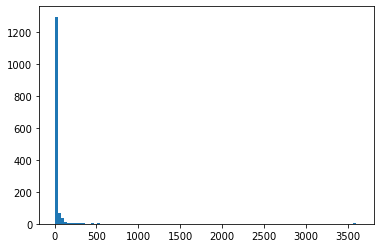

In [ ]:
plt.hist(RFPP_all,bins=100)

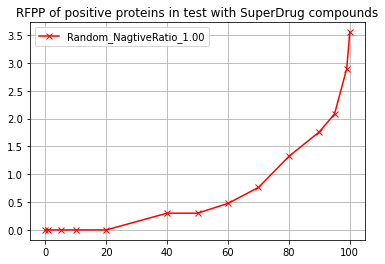

In [ ]:
plt.figure()
plt.plot(perntile_values,np.log10(Average_perntile),color='r',marker='x',label=Alpha_threshold+'_NagtiveRatio_{0:.2f}'.format(NegtiveRatio))
plt.grid()
plt.title('RFPP of positive proteins in test with SuperDrug compounds')
plt.legend()

In [ ]:
Average_perntile

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       2.0000e+00, 2.0000e+00, 3.0000e+00, 5.8000e+00, 2.1000e+01,
       5.8000e+01, 1.2180e+02, 7.9488e+02, 3.5730e+03])

In [ ]:
Average_perntile[:-3]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.6 , 0.8 , 1.  , 2.  , 2.2 , 5.66])

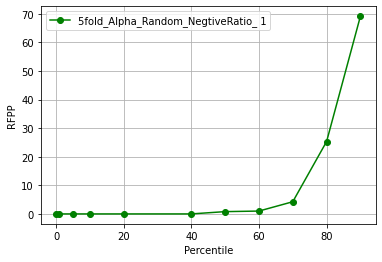

In [ ]:
NegativeRatio=1
import numpy as np
import matplotlib.pyplot as plt
path='/content/drive/MyDrive/CPI_Data/'
perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]
SuperDrugCompounds_Average_perntile_Random1=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values[0:-3],SuperDrugCompounds_Average_perntile_Random1[0:-3],color='g',marker='o',label='5fold_Alpha_Random_NegtiveRatio_{: .0f}'.format(NegativeRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()

In [ ]:
SuperDrugCompounds_Average_perntile_Random1

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 8.00000e-01, 1.00000e+00, 4.26000e+00, 2.53200e+01,
       6.91600e+01, 1.43280e+02, 2.13674e+03, 3.59340e+03])

In [ ]:
####RFPP
perntile_list=[]
for p in perntile_values:
  perntile=[]
  for fold in range(len(RFPP_Folds)):
    percent=np.percentile(RFPP_Folds[fold],p)
    print("p=",p,"percentile=",percent)
    perntile.append(percent)
  perntile_list.append(perntile)
Average_perntile=np.mean(perntile_list, axis=1)

p= 0 percentile= 0.0
p= 1 percentile= 0.0
p= 5 percentile= 0.0
p= 10 percentile= 0.0
p= 20 percentile= 0.0
p= 40 percentile= 1.0
p= 50 percentile= 1.0
p= 60 percentile= 1.0
p= 70 percentile= 4.0
p= 80 percentile= 10.800000000000011
p= 90 percentile= 59.0
p= 95 percentile= 92.0
p= 99 percentile= 1318.3300000000045
p= 100 percentile= 3620.0


No handles with labels found to put in legend.


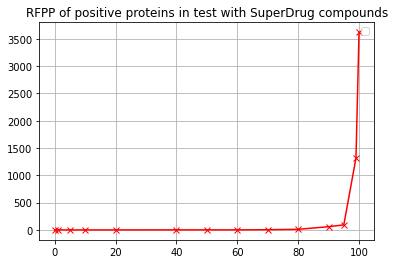

In [ ]:
plt.figure()
plt.plot(perntile_values,Average_perntile,color='r',marker='x')#,label='Random_NagtiveRatio_{:.2f}'.format(NegtiveRatio))
plt.grid()
plt.title('RFPP of positive proteins in test with SuperDrug compounds')
plt.legend()

In [ ]:
index_P=np.argsort(z)
n=len(Targetlabels)
sorted_index=index_P[::-1][:n]
sorted_score=z[index_P[::-1][:n]]
sorted_Targetlabels=Targetlabels[sorted_index]
RFPP=[]
#RFPP.append(np.where(sorted_Targetlabels==1))
for CC in P2C_dict[Pi]:
  print(CC)
  RFPP.append(np.where(sorted_Targetlabels==1))
  #RFPP.append(np.where(sorted_index == CC))
RFPP_list.append(np.min(RFPP)) 

164


In [ ]:
 np.save(path+'SuperDrugCompounds_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
path='/content/drive/MyDrive/CPI_Data/'
perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]
NegativeRatio=7
Alpha_threshold='Random'
SuperDrugCompounds_Average_perntile_Random7=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_7.npy')
plt.plot(perntile_values,np.log10 (SuperDrugCompounds_Average_perntile_Random7),color='r',marker='s',label='Negative Ratio:{: .0f}'.format(NegativeRatio))
###
#Random_SuperDrugCompounds_Average_perntile_Random7=np.load(path+'Random_SuperDrugCompounds_Average_perntile_Random_NegativeRatio_7.npy')
#plt.plot(perntile_values,np.log10 (Random_SuperDrugCompounds_Average_perntile_Random7),color='b',marker='D',label='Random Labels')# Ratio:{: .0f}'.format(NegativeRatio))
"""
Average_perntile_05=np.load(path+'Average_perntile_0.5_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_05,color='y',marker='d',label='5fold_Alpha_0.5_NegtiveRatio_{: .0f}'.format(NegativeRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()
###
1/0
"""
######
NegativeRatio=5
SuperDrugCompounds_Average_perntile_Random5=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10 (SuperDrugCompounds_Average_perntile_Random5),color='m',marker='^',label='Negative Ratio:{: .0f}'.format(NegativeRatio))
######
NegativeRatio=3
SuperDrugCompounds_Average_perntile_Random3=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10 (SuperDrugCompounds_Average_perntile_Random3),color='k',marker='x',label='Negative Ratio:{: .0f}'.format(NegativeRatio))
###
######
NegativeRatio=1
SuperDrugCompounds_Average_perntile_Random1=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,np.log10 (SuperDrugCompounds_Average_perntile_Random1),color='g',marker='o',label='Negative Ratio:{: .0f}'.format(NegativeRatio))
Random_SuperDrugCompounds_Average_perntile_Random1=np.load(path+'Random_SuperDrugCompounds_Average_perntile_Random_NegativeRatio_1.npy')
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('Log10 RFPP')
plt.legend()

In [ ]:
RFPP_all=[]
import numpy as np
path='/content/drive/MyDrive/CPI_Data/'
perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]
for f in range(5):
  fold=np.load(path+'fold'+str (f)+'_Superdrug_CPI_NN_RFPP_all.npy')
  RFPP_all=np.append(RFPP_all,fold)
Superdrug_CPI_NN_Average_perntile=np.percentile(RFPP_all,perntile_values)
np.save(path+'Superdrug_CPI_NN_Average_perntile.npy',Superdrug_CPI_NN_Average_perntile)

In [ ]:
fold

array([   5,   40,    5,    5,    6,   69,  280,    8, 1647, 1356,   11,
          8,   49,    6,    7,    8,    8,   45,    5,    7, 1647,    7,
          4,    9,    6,    6,  112,   23,    9,    6,    6,    7, 1647,
        344,    6,    4,    6,    5,   83,  280,  289,   68,    5,    5,
         16,    7,   18,    9,    7,    6,   42,    5,    5,    4,    4,
          5, 1640,    7, 1647,  107,    1, 1643,    8,  193,   49,    7,
        289,   11,  172,   18,  247, 1334,    7,   23,    7,    6, 1642,
          6,    6,    6,    5,    7,    8,    4,   23,  501,    6,    5,
          8, 1647,    7,    5, 1212,    6,    4,    9, 1163, 1647,    5,
         11,    7,   10,   11,    8,    9,    6,    8,    7,    6,    8,
          9,  122,  157,    7,    7,    6,   15,    6,  535,   17,    7,
          8,    9,    8,    4,    4,    5,    7,    6,    7,    6, 1163,
       1647,    5,   11,    7,   10,   11,    8,    9,    6,    8,    7,
          6,    8,    9,  122,  157,    7,    7,   

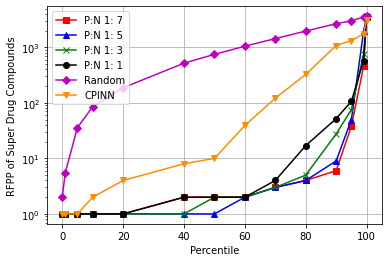

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
path='/content/drive/MyDrive/CPI_Data/'
perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]
####
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')
####
NegativeRatio=7
Average_perntile_Random7=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random7,color='r',marker='s',label='P:N 1:{: .0f}'.format(NegativeRatio))
###
"""
Average_perntile_05=np.load(path+'Average_perntile_0.5_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_05,color='y',marker='d',label='5fold_Alpha_0.5_NegtiveRatio_{: .0f}'.format(NegativeRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()
###
1/0
"""
######
NegativeRatio=5
Average_perntile_Random5=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random5,color='b',marker='^',label='P:N 1:{: .0f}'.format(NegativeRatio))
######
NegativeRatio=3
Average_perntile_Random3=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random3,color='g',marker='x',label='P:N 1:{: .0f}'.format(NegativeRatio))
###
######
NegativeRatio=1
Average_perntile_Random1=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_'+str (NegativeRatio)+'.npy')
plt.plot(perntile_values,Average_perntile_Random1,color='k',marker='o',label='P:N 1:{: .0f}'.format(NegativeRatio))
####
Random_Average_perntile_Random1=np.load(path+'Random_SuperDrugCompounds_Average_perntile_Random_NegativeRatio_1.npy')
plt.plot(perntile_values,Random_Average_perntile_Random1,color='m',marker='D',label='Random')
####CPI-NN
Superdrug_CPI_NN_allfolds=np.load(path+'Superdrug_CPI_NN_Average_perntile.npy')
plt.plot(perntile_values,Superdrug_CPI_NN_allfolds,color='darkorange',marker='v',label='CPINN')#'indigo'
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP of Super Drug Compounds')
plt.legend()
plt.rcParams['savefig.dpi'] = 1000
plt.show()
fig .savefig(path+"RFPPSuperDrugCompounds.pdf", bbox_inches='tight')

In [ ]:
SuperDrugCompounds_Average_perntile_Random5

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.3  ,  1.   ,
        1.84 ,  3.2  ,  5.2  ,  9.27 , 16.678, 97.   ])

In [ ]:
SuperDrugCompounds_Average_perntile_Random3

array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.8  ,
         1.   ,   1.8  ,   3.   ,   5.   ,  10.57 ,  23.244, 129.   ])

In [ ]:
SuperDrugCompounds_Average_perntile_Random1

array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.8  ,
         1.   ,   2.   ,   3.   ,   5.9  ,  10.16 ,  25.852, 126.6  ])

In [ ]:
import pandas as pd
path='/content/drive/MyDrive/CPI_Data/'
df_Superdrug=pd.read_excel(path+'approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values#index_col=2)

In [ ]:
RFPP_Folds

In [ ]:
np.save(path+'SuperDrugCompounds_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)

In [ ]:
np.save(path+'SuperDrugCompounds_Average_perntile_'+str (Alpha_threshold)+'_NegativeRatio_'+ str (NegtiveRatio)+'.npy',Average_perntile)

In [ ]:
import matplotlib.pyplot as plt
Average_perntile=np.load(path+'SuperDrugCompounds_Average_perntile_Random_NegativeRatio_7.npy')
plt.plot(perntile_values,Average_perntile,color='r',marker='x',label=Alpha_threshold+'_NagtiveRatio_7{0:.2f}'.format(NegtiveRatio))
plt.grid()
plt.title('RFPP of positive proteins in test with SuperDrug compounds')
plt.legend()

In [ ]:
SuperDrugCompounds_Average_perntile7=Average_perntile

In [ ]:
SuperDrugCompounds_Average_perntile7

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.8 ,   1.  ,
         1.8 ,   2.6 ,   4.98,   9.1 ,  34.41, 121.  ])

In [ ]:
Average_perntile

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.3  ,  1.   ,
        1.84 ,  3.2  ,  5.2  ,  9.27 , 16.678, 97.   ])

In [ ]:
np.array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.   ,1.   ,   2.   ,   3.   ,   5.2  ,  10.02 ,  25.212, 129.   ])

485

In [ ]:
P2C_dict[Pi]

In [ ]:
RFPP

In [ ]:
Actual_Scores

In [ ]:
Actual_Compound

In [ ]:
z

In [ ]:
Ctt=np.vstack((Actual_Compound_Features,Superdrug_CFeatures ))#Features all unique Compounds of Superdrugbank and truepositive examples
Ptt=np.array([Pi_Feature for i in range(len(Ctt))])#Copy same feature of protein equal to number of unique compounds
#Ctt=Pos_CFeatures #Features all unique Compounds of Human dataset
Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)
Kp = kernel(Ptt,Ptr)
Kc = kernel(Ctt,Ctr)
Ktt = (Kp+Kc)**2# (Kp**2+Kc**2+2*Kp*Kc)
z = clf.decision_function(Ktt)
Actual_Scores=z[0:len(Actual_Compound_Features)]
#####
index_P=np.argsort(z)
n=len(Pos_CFeatures)
sorted_index=index_P[::-1][:n]
sorted_score=z[index_P[::-1][:n]]
RFPP=[]
for comp_score in Actual_Scores:
  RFPP.append(np.where(sorted_score == comp_score ))
RFPP_list.append(np.min(RFPP)) 

In [ ]:
#####
index_P=np.argsort(z)
n=len(Ctt)
sorted_index=index_P[::-1][:n]
sorted_score=z[index_P[::-1][:n]]
RFPP=[]
for CC in P2C_dict[Pi]:
  RFPP.append(np.where(sorted_index == CC))
RFPP_list.append(np.argmin(RFPP)) 

In [ ]:
np.where(sorted_index == CC)

(array([629]),)

In [ ]:
RFPP_list

[88, 32]

In [ ]:
RFPP

[(array([1834]),),
 (array([3117]),),
 (array([1251]),),
 (array([1884]),),
 (array([776]),),
 (array([390]),),
 (array([1492]),),
 (array([2260]),),
 (array([804]),),
 (array([2376]),),
 (array([3083]),),
 (array([710]),),
 (array([384]),),
 (array([2362]),),
 (array([678]),),
 (array([3546]),),
 (array([3615]),),
 (array([453]),),
 (array([2328]),),
 (array([3722]),),
 (array([1462]),),
 (array([3682]),),
 (array([3545]),),
 (array([2578]),),
 (array([874]),),
 (array([3004]),),
 (array([1027]),),
 (array([3778]),),
 (array([1838]),),
 (array([3255]),),
 (array([1531]),),
 (array([870]),),
 (array([6]),),
 (array([3305]),),
 (array([1019]),),
 (array([1079]),),
 (array([2220]),),
 (array([1739]),),
 (array([1245]),),
 (array([3143]),),
 (array([960]),),
 (array([3746]),),
 (array([3217]),),
 (array([2267]),),
 (array([2997]),),
 (array([2059]),),
 (array([3791]),),
 (array([3400]),),
 (array([2358]),),
 (array([838]),),
 (array([2171]),),
 (array([1469]),),
 (array([3363]),),
 (array

In [ ]:
Actual_Scores=z[0:len(Actual_Compound_Features)]

In [ ]:
Actual_Scores

array([1.00027437])

In [ ]:
sorted_score[0]

1.881256871023356

In [ ]:
for CC in P2C_dict[Pi]:
  RFPP.append(np.where(sorted_index == CC))

In [ ]:
CC

157

In [ ]:
z[0]

1.000274371451187

In [ ]:
np.where(sorted_score == z[0])

array([1.00027437])

In [ ]:
index_P=np.argsort(z)
n=len(Pos_CFeatures)
sorted_index=index_P[::-1][:n]
sorted_score=z[index_P[::-1][:n]]

In [ ]:
z

array([ 1.00027437, -0.74539935, -0.54645397, ..., -0.70872892,
       -0.56872201, -0.8512675 ])

In [ ]:
Actul_Compound=P2C_dict[Pi]#Actul_Compound paired with Pi
Actul_Compound_Features=np.array([Unique_Compounds_Features_dict[c] for c in Actul_Compound])
1/0

ZeroDivisionError: ignored

In [ ]:
Actul_Compound_Features

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [ ]:
P2C_dict

defaultdict(list,
            {0: [58],
             1: array([ 69, 450]),
             2: [459],
             3: [12],
             4: [642],
             5: array([459, 680]),
             6: [459],
             7: [459],
             8: array([711, 445, 835]),
             9: array([757, 459]),
             10: [1115],
             11: [757],
             12: array([ 557,  743, 1038, 1150,  202,  164,  732,  572,  904,  587,  319,
                     749,  757,  241,  172,   26]),
             13: [704],
             14: array([ 564, 1161]),
             15: array([125, 485, 912, 505, 870]),
             16: [732],
             17: array([1052,  333,  450]),
             18: [1019],
             19: array([ 963, 1105]),
             20: [767],
             21: array([459, 757]),
             22: [704],
             23: [704],
             24: [134],
             25: [900],
             26: [459],
             27: [459],
             28: array([459, 704, 638]),
             29: arra

In [ ]:
import pandas as pd
df_Superdrug=pd.read_excel(path+'approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values#index_col=2)
df_Superdrug=df_Superdrug[1:]
df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
df_Superdrug_Compounds=list (set (df_Superdrug_Compounds))#only unique 3633
Superdrug_CFeatures = np.array([getFP(s) for s in df_Superdrug_Compounds])

RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:55:02] WARNING: not r

In [ ]:
for s in df_Superdrug_Compounds:
  print(s)
  1/0

C[C@@]12CCCCC[C@@H](Cc3ccc(O)cc31)[C@@H]2N


ZeroDivisionError: ignored

In [ ]:
Superdrug_CFeatures

array([[0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [ ]:
#CANONICAL_SMILES
path='/content/drive/MyDrive/CPI_Data/'
import pandas as pd
df_Superdrug=pd.read_excel(path+'approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values#index_col=2)
df_Superdrug=df_Superdrug[1:]
df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])
1/0
hemo_score_HemoPred=df_hemo[['Prediction']].values
df_non_hemo = pd.read_csv(path+'new_HemoPred_predicted_results_NON_hemo_AllSeq_data.csv')
non_hemo_score_HemoPred=df_non_hemo[['Prediction']].values


ZeroDivisionError: ignored

In [ ]:
import numpy as np

df_Superdrug_new=np.array([c[0] for c in df_Superdrug])#should pick only unique compounds

In [ ]:
len(df_Superdrug_new)

3638

In [ ]:
df_Superdrug_new=list (set (df_Superdrug_new))

In [ ]:
df_Superdrug_new

['C[C@@]12CCCCC[C@@H](Cc3ccc(O)cc31)[C@@H]2N',
 'COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC',
 'CC(=O)N(CCC(CCN1CCCCC1)(C(N)=O)c1ccccc1Cl)C(C)C',
 'CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1',
 'CN1C(=O)CN=C(c2ccccc2F)c2cc(Cl)ccc21',
 'CC[C@]12CCCN3CCc4c(n(c5cc(Br)ccc45)[C@@](O)(C(=O)OC)C1)[C@@H]32',
 'FC(F)(F)C(F)(F)C(F)(F)N(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F',
 'COc1cc2nccc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)CC4)cc3)c2cc1OC',
 'CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2',
 'CC(C)(C)c1nnc(NS(=O)(=O)c2ccccc2)s1',
 'CN1CCC(=C2c3ccccc3CCc3cccnc32)CC1',
 'CC(C)(Oc1ccc(Cl)cc1)C(=O)O',
 'C=CCCCCCCCCC(=O)O',
 'CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)c1ccccc1O',
 'COc1ccccc1OC(=O)c1ccccc1OC(C)=O',
 'O=C1[C@H]2[C@@H]3CC[C@@H](C3)[C@H]2C(=O)N1CCCCN1CCN(c2ncccn2)CC1',
 'CO/N=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=CCS[C@H]12)c1csc(N)n1',
 'CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3',
 'COC(=O)C1=C(C)NC(C)=C(C(=O)O[C@@H]2CCCN(Cc3ccccc3)C2)C1c1cccc([N+](=O)[O-])c1',
 'Oc1ccc(C(O)CN

In [ ]:
for c in df_Superdrug:
  print(c[0])
  1/0

CCCCN1CCCC[C@H]1C(=O)Nc1c(C)cccc1C


ZeroDivisionError: ignored

In [ ]:
len(df_Superdrug)

3639

In [ ]:
df_Superdrug=df_Superdrug[1:]

In [ ]:
df_Superdrug[0]

KeyError: ignored

In [ ]:
df_Superdrug=df_Superdrug.drop_duplicates

AttributeError: ignored

In [ ]:
len(df_Superdrug)

TypeError: ignored

In [ ]:
import numpy as np


In [ ]:
df_Superdrug.columns.ravel()

array(['Column1', 'Column2', 'Column3', 'Column4', 'Column5'],
      dtype=object)

In [ ]:
print(df_Superdrug)

                                                Column3
0                                      CANONICAL_SMILES
1                    CCCCN1CCCC[C@H]1C(=O)Nc1c(C)cccc1C
2     COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)[C...
3     CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)[C@@H]1c1cccc([...
4               C[C@@H](CCc1ccc(O)cc1)NCCc1ccc(O)c(O)c1
...                                                 ...
3634  CCOc1ccc(Cc2cc([C@]34OC[C@](CO)(O3)[C@@H](O)[C...
3635  COc1cccc(N2CCN(C3=Nc4c(F)cccc4[C@H](CC(=O)O)N3...
3636  CC(C)(N)C(=O)N[C@H](Cc1c[nH]c2ccccc12)C(=O)N[C...
3637  Cc1ccc(C(=O)OCc2ccc([C@@H](CN)C(=O)Nc3ccc4cncc...
3638  CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...

[3639 rows x 1 columns]


In [ ]:
import pandas as pdperntile_values = [0,2,5,10,20,40,50,60,70,80,90,100]
perntile_list=[]
for p in perntile_values:
  perntile=[]
  for fold in range(len(RFPP_Folds)):
    perntile.append(np.percentile(RFPP_Folds[fold],p))
  perntile_list.append(perntile)
Average_perntile_07_NegativeRatio_1=np.mean(perntile_list, axis=1)
np.save(path+'Average_perntile_0.7_NegativeRatio_1.npy',Average_perntile_07_NegativeRatio_1)

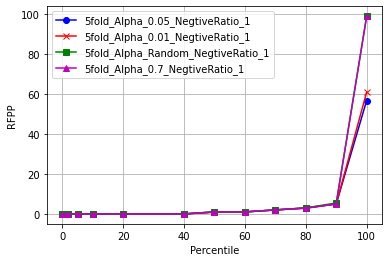

In [ ]:
Average_perntile_001_NegativeRatio_1=np.load(path+'Average_perntile_0.01_NegativeRatio_1.npy')
Average_perntile_005_NegativeRatio_1=np.load(path+'Average_perntile_005_NegativeRatio_1.npy')
Average_perntile_Random_NegativeRatio_1=np.load(path+'Average_perntile_Random_NegativeRatio_1.npy')
Average_perntile_07_NegativeRatio_1=np.load(path+'Average_perntile_0.7_NegativeRatio_1.npy')
plt.plot(perntile_values,Average_perntile_005_NegativeRatio_1,color='b',marker='o',label='5fold_Alpha_0.05_NegtiveRatio_1')#0.005_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
#plt.plot(perntile_values,Average_perntile,color='b',marker='D',label='5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.plot(perntile_values,Average_perntile_001_NegativeRatio_1,color='r',marker='x',label='5fold_Alpha_0.01_NegtiveRatio_1')#5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.plot(perntile_values,Average_perntile_Random_NegativeRatio_1,color='g',marker='s',label='5fold_Alpha_Random_NegtiveRatio_1')
plt.plot(perntile_values,Average_perntile_07_NegativeRatio_1,color='m',marker='^',label='5fold_Alpha_0.7_NegtiveRatio_1')

plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()

In [ ]:
Average_perntile_Random_NegativeRatio_1

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  1.  ,  2.  ,
        3.  ,  5.48, 99.  ])

In [ ]:
Average_perntile_07_NegativeRatio_1

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  2. ,  2.8,  5. ,
       99. ])

In [ ]:
Average_perntile_005_NegativeRatio_1

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  1.  ,  2.  ,
        3.  ,  4.96, 56.8 ])

In [ ]:
Average_perntile_001_NegativeRatio_1

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.8,  1. ,  2. ,  3. ,  5. ,
       61. ])

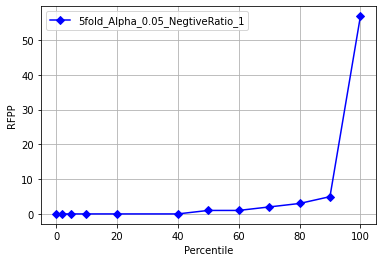

In [ ]:
perntile_values = [0,2,5,10,20,40,50,60,70,80,90,100]
perntile_list=[]
colors=['r','g','b']
for p in perntile_values:
  perntile=[]
  for fold in range(len(RFPP_Folds)):
    perntile.append(np.percentile(RFPP_Folds[fold],p))
  perntile_list.append(perntile)

Average_perntile_005_NegativeRatio_1=np.mean(perntile_list, axis=1)
np.save(path+'Average_perntile_005_NegativeRatio_1.npy',Average_perntile_005_NegativeRatio_1)
plt.plot(perntile_values,Average_perntile_005_NegativeRatio_1,color='b',marker='D',label='5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
#plt.plot(perntile_values,Average_perntile,color='b',marker='D',label='5fold_Alpha_{0:.2f}_NegtiveRatio_{1:.0f}'.format(Alpha_threshold,NegtiveRatio))
plt.grid()
plt.xlabel('Percentile')
plt.ylabel('RFPP')
plt.legend()

In [ ]:
Average_perntile

11.833333333333334

In [ ]:
import matplotlib.pyplot as plt

a = np.arange(4)
perntile = [0,2,5,10,20,40,50,60,70,80,90,100]
for interpolation, style in lines:
    ax.plot(
        p, np.percentile(a, p, interpolation=interpolation),
        label=interpolation, linestyle=style)
ax.set(
    title='Interpolation methods for list: ' + str(a),
    xlabel='Percentile',
    ylabel='List item returned',
    yticks=a)
ax.legend()
plt.show()